In [2120]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import ipywidgets as wi
from tqdm.notebook import tqdm
import scipy as sc
import scipy.optimize as opt
import scipy.linalg as la
import torch
import torchvision
# from torchviz import make_dot

device='cuda'

In [2121]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/1')


In [2191]:
testPath = os.path.join('Dataset', 'Bikes.avi')
# testPath = os.path.join('Dataset', 'WIN_20191220_10_52_27_Pro.mp4')
# testPath = os.path.join('Dataset', '-2.5', 'video.avi')
# testPath = os.path.join('Dataset', '-3.5', 'video.avi')

max_num = 10
max_features=10000

In [2192]:
def loadClip(fullpath=testPath):
    cap = cv2.VideoCapture(fullpath);
    if(not cap.isOpened()):
        return
    try:
        num_image=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#         print(num_image)
        num_image = max_num if (num_image>max_num) else num_image; #only first 30
        imgs =[cap.read()[1][:,:,::-1] for _ in range(num_image)]
        return imgs
    finally:
        cap.release()

#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

In [2193]:
imgs = loadClip()
# imgs = [cv2.resize(img, (0, 0), fx=0.5, fy=0.5) for img in imgs]
# imgs = [imgs[0] for _ in range(len(imgs))]
grays = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in imgs]
# plt.imshow(grays[0], cmap='gray')

In [2194]:
ref = grays[0]
ref_features = cv2.goodFeaturesToTrack(ref, max_features, 1e-10, 5)[:, 0, :]

In [2195]:
inlier_mask = np.ones(ref_features.shape[0], dtype='bool')

In [2196]:
corners_fwd, corners_bwd, status_fwd, status_bwd, err_fwd, err_bwd = None, None, None, None, None, None
_ = cv2.calcOpticalFlowPyrLK(ref, grays[1], ref_features, None)

In [2197]:
features = []
inlier_mask = np.ones((len(ref_features),1), dtype='bool')
corners_ref = ref_features
for i in tqdm(range(1, len(grays))):
    corners_fwd, st_fwd, err = cv2.calcOpticalFlowPyrLK(ref, grays[i], corners_ref, None)
    corners_bwd, st_bwd, err = cv2.calcOpticalFlowPyrLK(grays[i], ref, corners_fwd, None)
    bidir_err = np.linalg.norm(corners_ref-corners_bwd, axis=1, keepdims=True)
    inlier_mask = inlier_mask & (st_fwd!=0) & (st_bwd!=0) & (bidir_err<0.1)
    features.append(corners_fwd)
inlier_mask = inlier_mask.flatten()

In [2198]:
n_features = len(ref_features)
n_frames = len(features)
print(n_features, n_frames)

10000 9


In [2199]:
sel_features = np.array(features)[:, inlier_mask]
sel_ref_features = ref_features[inlier_mask]
sh = sel_features.shape
print(sh)

(9, 9793, 2)


In [2202]:
def plot_with_keypoints(i):
    step = 1
    plt.figure(figsize=(10,10))
    plt.imshow(imgs[i])
    if i==0:
        features = sel_ref_features
    else:
        features = sel_features[i-1]
    plt.scatter(features[::step, 0], features[::step, 1], s=1, c='r')
#     plt.axis('off')
#     plt.savefig(str(i))
_ = wi.interact(plot_with_keypoints, i=wi.IntSlider(0,0,len(grays)-1))

interactive(children=(IntSlider(value=0, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

In [2203]:
# import imageio
# images = []
# for filename in [str(i)+'.png' for i in range(n_frames)]:
#     images.append(imageio.imread(filename))
# imageio.mimsave('movie2.gif', images)

In [2204]:
# ref_features = sel_ref_features
# all_features = []
# for frame in range(sel_features.shape[0]):
#     features = sel_features[frame] 

#     features_c = features - features.mean(axis=0)
#     ref_features_c = ref_features - ref_features.mean(axis=0) 
#     # https://en.wikipedia.org/wiki/Procrustes_analysis
#     up = features_c[:, 0]@ref_features_c[:, 1]-features_c[:, 1]@ref_features_c[:, 0]
#     down = features_c[:, 0]@ref_features_c[:, 0]-features_c[:, 1]@ref_features_c[:, 1]
#     theta = np.arctan2(up, down)

#     rot = np.array([[np.cos(theta), np.sin(theta)],
#                     [-np.sin(theta), np.cos(theta)]])
#     new = -features@rot
#     new = np.concatenate((new, np.ones((new.shape[0], 1))), axis=1)
    
    
#     all_features.append(new.T)
    
# all_features = np.concatenate(all_features, axis=0)

# U, s, Vh = la.svd(all_features)

# b, d = U[:, 0], Vh[0, :]

In [2205]:
focus_scale = 1000

In [2206]:
def L(x, c, uv0, uv):
    """
    x - concatenated variables we try to find (optimize by them)
    c - image center coordinates in image space (width/2, height/2)
    uv0 - array of features coordinates for reference frame
    uv - array of features coordinates for the rest of frames
    
    """
    f, k1, k2 = x[:3] #camera intristic parameter (focus, distortion)
    f*=focus_scale #scale
    rx, ry, rz, tx, ty, tz = camera = np.hsplit(x[3:3+6*n_frames].reshape((n_frames, 6)), 6) #rotation/translation
    cx, cy = c 
    w = np.array(x[3+6*n_frames:]) #inverse_depths for each feature point
    uv0 = uv0 - c # center
    r20_ = np.sum((uv0/f)**2, axis=-1, keepdims=True)
    dist = 1 + k1*r20_ + k2*r20_**2
    uv0 = uv0*dist # account for distortion
    # get components for easier calculations?
    u0 = uv0[:, 0] 
    v0 = uv0[:, 1]
    # R(r_i)x_j+t_i
    p = [u0 - rz*v0 + f*ry + f*tx*w, 
         rz*u0 + v0 - f*rx + f*ty*w,
         -ry*u0 + rx*v0 + f + f*tz*w]
    
    # <>
    uvp = f*np.array(p[:2])/p[2] 
    # order
    uvp = np.transpose(uvp, (1, 2 ,0))
    
    # second term of loss
    uv = uv-c
    r2_ = np.sum((uv/f)**2, axis=-1, keepdims=True)
    dist = 1 + k1*r2_ + k2*r2_**2
    uv = uv*dist
    return (uv-uvp).ravel()

In [2207]:
w_min=0.01
w_max=1.0
print(sh)
w = w_min + np.random.rand(sh[1]) * (w_max - w_min)

(9, 9793, 2)


In [2208]:
shape = height, width = grays[0].shape
c = np.array(shape)[::-1]/2

In [2209]:
rt = np.zeros((n_frames, 6))
internal = f_init, k1_init, k2_init = [width if width>height else height, 0, 0]
internal[0] /= focus_scale
x = np.concatenate((internal, rt.ravel(), w))

In [2210]:
n = np.prod(sel_features.shape)
m = len(x)
A = sc.sparse.lil_matrix((n, m), dtype=int)
print(A.shape)
A[:, :3] = 1
for i in range(n_frames):
    A[i*2*n_features:(i+1)*2*n_features, 3 + i*6:3 + (i+1)*6] = 1 #(i+1)

# A[i*2*n_features:(i+1)*2*n_features, 3 + i*6:3 + (i+2)*6] = 1 #(i+1)
st = 3 + n_frames*6
for j in range(0, n):
#     k = (j/2)%len(w)
    A[j, st + (j//2)%len(w)] = 1

(176274, 9850)


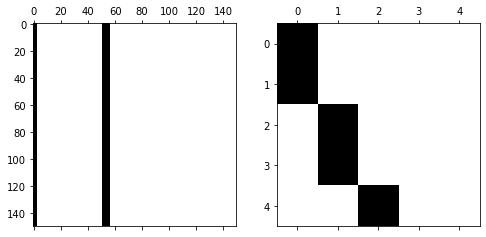

In [2211]:
f, ax = plt.subplots(1, 2, figsize=(8,6))
ax[0].spy(A[-150:, :150].todense())
ax[1].spy(A[:5, st:st+5].todense())

In [ ]:
#loss='‘huber’' 
def bundle_adjustment():
    return opt.least_squares(L, x, jac_sparsity=A,
                        loss='soft_l1', verbose=2, x_scale='jac', xtol=1e-12,
                        args=(c, sel_ref_features, sel_features), max_nfev=300)
res = bundle_adjustment()

Text(0.5, 0, 'residual №')

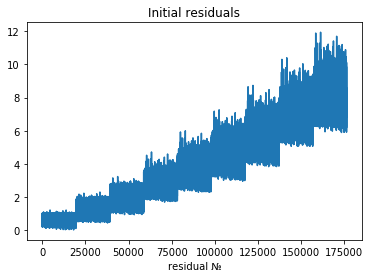

In [2213]:
plt.plot(L(x, c, sel_ref_features, sel_features))
plt.title(label='Initial residuals')
plt.xlabel('residual №')

Text(0.5, 0, 'residual №')

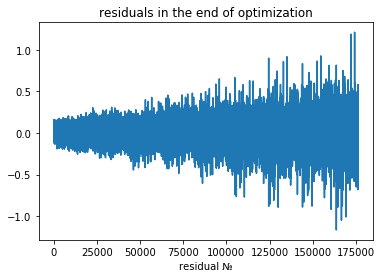

In [2215]:
plt.plot(res.fun)
plt.title('residuals in the end of optimization')
plt.xlabel('residual №')

In [2216]:
res_f, res_k1, res_k2 = res.x[:3]
res_f*=focus_scale
print('focus_distance: ', res_f)
print('distortion k1, k2:', res_k1, res_k2)

focus_distance:  1777.596576096924
distortion k1, k2: -0.05261794453132868 0.033619774121096874


In [2217]:
x[-len(w):]

array([0.63029456, 0.69431573, 0.60178227, ..., 0.58573757, 0.12682966,
       0.11853175])

In [2218]:
inverse_depths = res.x[-len(w):]
inverse_depths_norm = res.x[-len(w):]/max(inverse_depths)
depths = 1/inverse_depths
depths = (depths-min(depths))/(max(depths) - min(depths))

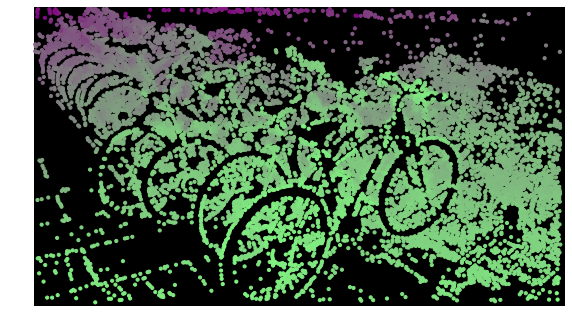

In [2219]:
plt.figure(figsize=(10,10))
plt.imshow(np.zeros_like(imgs[0]))
# color = np.stack((1-depths for _ in range(3)), axis=1)
color = np.ones((depths.shape[0], 3))/2
color[:, 1] = 1-depths
plt.scatter(sel_ref_features[:, 0], sel_ref_features[:, 1], c=color, s=10)
plt.axis('off')
plt.savefig('feature_depth', bbox_inches='tight')

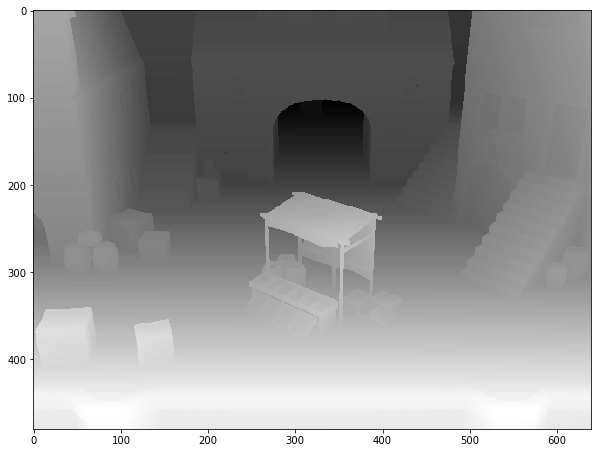

In [2220]:
GTdepth = np.loadtxt(os.path.join('Dataset', 'LabelGT.txt'))
plt.figure(figsize=(10,10))
plt.imshow(GTdepth, cmap='gray')

In [2221]:
a = torch.randn(1, requires_grad=True, dtype=torch.float, device='cuda')
b = torch.randn(1, requires_grad=True, dtype=torch.float, device='cuda')
print(a, b)

tensor([1.7726], device='cuda:0', requires_grad=True) tensor([0.6064], device='cuda:0', requires_grad=True)


In [494]:
x_train = torch.from_numpy(x).to(device)
x_train

tensor([1.9200, 1.1000, 1.1000,  ..., 0.0972, 0.6077, 0.9851], device='cuda:0',
       dtype=torch.float64)

(480, 640, 3)


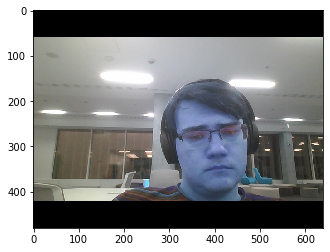

In [45]:
cap = cv2.VideoCapture(0);
cap.isOpened()
ret, frame = cap.read()
print(frame.shape)
plt.imshow(frame)

cap.release()
cv2.destroyAllWindows()